In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mat73
from scipy import signal
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, medfilt

In [2]:
def read_emg(filepath):
    mat_data = mat73.loadmat(filepath)
    out_mat = mat_data['out_mat']
    grid_crds = mat_data['grid_crds']
    return grid_crds,out_mat

def butter_bandpass(lowcut, highcut, fs, order=5):
  nyq = 0.5 * fs
  b, a = signal.butter(order, [lowcut/ nyq, highcut/ nyq], btype='band', analog=False)
  return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
  b, a = butter_bandpass(lowcut, highcut, fs, order=order)
  y = signal.filtfilt(b, a, data)
  return y
def notch(notch_freq, samp_freq, quality_factor=30):
  b, a = signal.iirnotch(notch_freq, quality_factor, samp_freq)
  return b, a
def notch_filter(data, notch_fs, fs, q=30):
  b, a = notch(notch_fs, fs, q)
  y = signal.filtfilt(b, a, data)
  return y
def filt_GRID(data, lowcut=20, highcut=500, fs=4000, order=3, notch_fs = 50, notch_q = 30):
  filt_out = np.zeros_like(data)
  for i in range(data.shape[0]):
    filt_out[i,:] = notch_filter(butter_bandpass_filter(data[i,:], lowcut, highcut, fs,
    order=order), notch_fs, fs, notch_q)
  return filt_out

In [3]:
grid,data1 = read_emg('11755 F23 project data/increasing force 1.mat')
grid,data2 = read_emg('11755 F23 project data/increasing force 2.mat')
grid,data3 = read_emg('11755 F23 project data/steady force 1.mat')

filtered_data1=filt_GRID(data1)
filtered_data2=filt_GRID(data2)
filtered_data3=filt_GRID(data3)


In [4]:
distance = 10   # A typical interspike interval for MUAPs in EMG; adjust as needed.
window_length = 21
peak_duration = 30*2

def detect_peaks_adaptive(signal, window_length=100, k=3, distance=None):
    # Compute a local baseline (e.g., using median filtering)
    local_baseline = medfilt(signal, window_length)
    # Compute the local noise level (robust estimate using median absolute deviation)
    local_noise = np.median(np.abs(signal - local_baseline))
    # Define adaptive threshold
    adaptive_threshold = local_baseline + k * local_noise
    # Detect peaks above the adaptive threshold
    peaks, _ = find_peaks(signal, height=adaptive_threshold, distance=distance)
    return peaks

def get_peaks(x,window_length=window_length,distance=distance):
    peaks = detect_peaks_adaptive(x, window_length=window_length, k=2, distance=distance)
    peak_thres = np.mean(x[peaks])
    peaks = peaks[x[peaks]>peak_thres]
    return peaks

def get_peak_data(x,peak_pos,peak_duration=peak_duration):
    start_pos = int(peak_pos-peak_duration/2)
    end_pos = int(peak_pos+peak_duration/2)
    if start_pos<0 or end_pos>=len(x):
        return None
    return x[start_pos:end_pos]

def viz_peaks(x,peaks):
    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(x)
    plt.plot(peaks, x[peaks], "ro")
    plt.title('Peak Detection in EMG with Increasing Force - Adaptive Thresholding')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

In [5]:
class FiringInstance():
    def __init__(self,channel_num,peak_pos,peak_form):
        self.channel_num = channel_num
        self.peak_pos = peak_pos
        self.peak_form = peak_form
        self.used = False
        self.mean_waveform = None
        self.wavelet = None
        self.data_file = None

In [6]:
def get_channel_distances(filtered_data,data_file):
    final_grid = [[ [] for _ in range(8) ] for _ in range(8)]
    for i in range(8):
        for j in range(8):
            channel = 8*i+j
            x = filtered_data[channel]
            peaks = get_peaks(x)
            for peak_pos in peaks:
                peak_form = get_peak_data(x,peak_pos)
                if peak_form is not None:
                    fi = FiringInstance(channel,peak_pos,peak_form)
                    fi.data_file = data_file
                    final_grid[i][j].append(fi)
    return final_grid    

In [7]:
final_grid1 = get_channel_distances(filtered_data1,"if1")
final_grid2 = get_channel_distances(filtered_data2,"if2")
final_grid3 = get_channel_distances(filtered_data3,"sf1")

In [9]:
final_waveforms = []
kernel_size = 3

def get_mean_peak_form(final_grid,x_fi,i,j,kernel_size=kernel_size):
    mean_waveform = np.zeros(peak_duration)
    count = 0
    agg_hist = []
    for p in range(max(0,i-kernel_size//2),i+1):
        for q in range(max(0,j-kernel_size//2),min(7,j+kernel_size//2)+1):
            channel_data = final_grid[p][q]
            for fi in channel_data:
                if (fi.peak_pos == x_fi.peak_pos or fi.peak_pos == x_fi.peak_pos+1 ):
                    mean_waveform += fi.peak_form
                    fi.used = True
                    count += 1
                    agg_hist.append(fi)
    mean_waveform/=count
    for fi in agg_hist:
        fi.mean_waveform = mean_waveform
    return mean_waveform

def get_final_waveforms(final_grid):
    for i in range(7,-1,-1):
        for j in range(7,-1,-1):
            for x_fi in final_grid[i][j]:
                    if x_fi.used==False:
                        mean_waveform = get_mean_peak_form(final_grid,x_fi,i,j)
                        x_fi.mean_waveform = mean_waveform
                        final_waveforms.append(x_fi)


In [10]:
get_final_waveforms(final_grid1)
get_final_waveforms(final_grid2)
get_final_waveforms(final_grid3)

In [11]:
import pywt
for signal in final_waveforms:
    (CA,CD) = pywt.dwt(signal.mean_waveform, 'db6')
    signal.wavelet = np.concatenate([CA,CD],axis=0)

In [12]:
import numpy as np

def normalize_data(data):
    min_val = min(data)
    max_val = max(data)
    return [(point - min_val) / (max_val - min_val) for point in data]

def calculate_angles(wcss):
    angles = []
    for i in range(1, len(wcss) - 1):
        p1 = np.array([i, wcss[i]])
        p2 = np.array([i - 1, wcss[i - 1]])
        p3 = np.array([i + 1, wcss[i + 1]])

        v1 = p1 - p2
        v2 = p1 - p3

        angle = np.math.atan2(np.linalg.det([v1, v2]), np.dot(v1, v2))
        angles.append(np.abs(angle))

    return angles

def find_elbow_point(wcss):
    normalized_wcss = normalize_data(wcss)
    angles = calculate_angles(normalized_wcss)
    elbow_point = angles.index(max(angles)) + 1  # Adding 1 because index starts from 0

    return elbow_point

In [13]:
def get_k_elbow(wcss):
    diff,ans = 0,-1
    for i in range(1,len(wcss)):
        temp_diff = abs(wcss[i]-wcss[i-1])
        if temp_diff>diff:
            ans,diff = i,temp_diff
    return ans

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = np.array([signal.wavelet for signal in final_waveforms])
X = scaler.fit_transform(X)


45


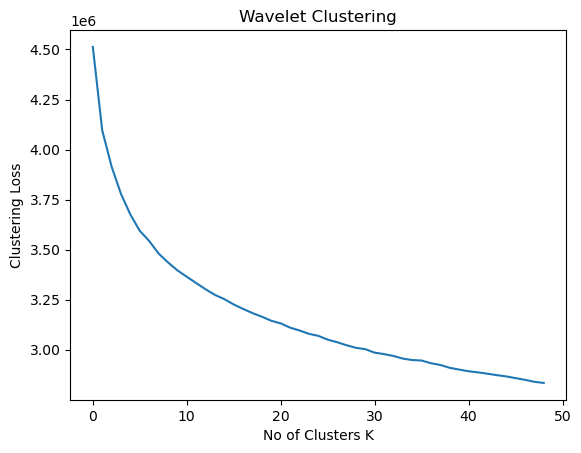

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = [] 
for i in range(1, 50): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,n_init="auto")
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)
# print(np.argmax(np.array(arr)))
# print(np.argsort(arr))
plt.plot(wcss)
plt.title("Wavelet Clustering")
plt.xlabel("No of Clusters K")
plt.ylabel("Clustering Loss")
print(find_elbow_point(wcss))

In [17]:
from sklearn.decomposition import PCA


pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)

[0.154282   0.09619804 0.07938429 0.06889466 0.06381308 0.0624802
 0.05800098 0.05438386 0.04964037 0.04442354]


28


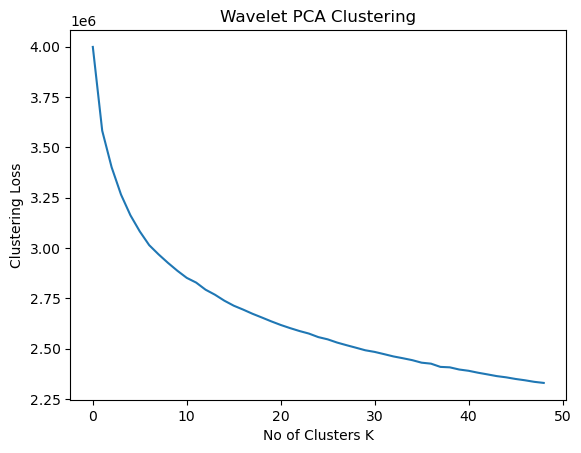

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

pca = PCA(n_components=15)
features_pca = pca.fit_transform(X)
wcss = [] 
for i in range(1, 50): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,n_init="auto")
    kmeans.fit(features_pca) 
    wcss.append(kmeans.inertia_)
plt.plot(wcss)
plt.title("Wavelet PCA Clustering")
plt.xlabel("No of Clusters K")
plt.ylabel("Clustering Loss")
print(find_elbow_point(wcss))

24


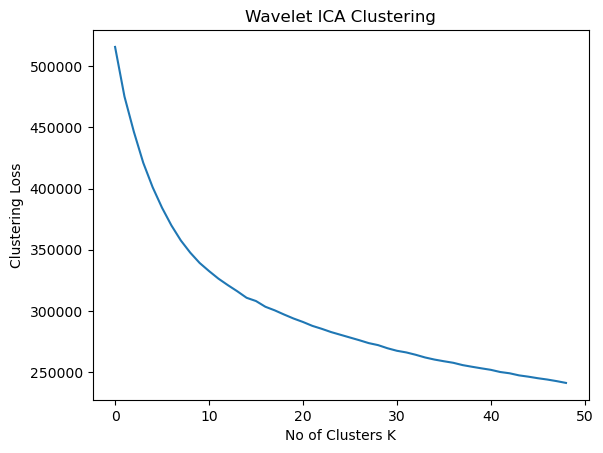

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

transformer = FastICA(n_components=8,
         random_state=0,
         whiten='unit-variance',
         max_iter=1000)

features_ica = transformer.fit_transform(X)
wcss = [] 
for i in range(1, 50): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,n_init="auto")
    kmeans.fit(features_ica) 
    wcss.append(kmeans.inertia_)
plt.plot(wcss)
plt.title("Wavelet ICA Clustering")
plt.xlabel("No of Clusters K")
plt.ylabel("Clustering Loss")
print(find_elbow_point(wcss))

34


Text(0, 0.5, 'Clustering Loss')

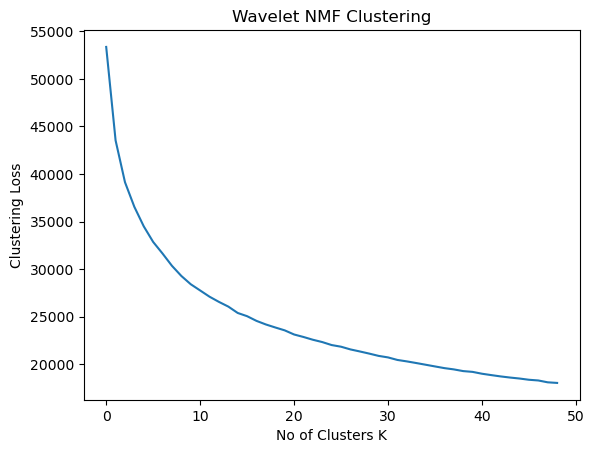

In [20]:
from sklearn.decomposition import NMF
model = NMF(n_components=7, init='random', random_state=0,max_iter=5000)
features_nmf = model.fit_transform(X-np.min(X))

wcss = [] 
for i in range(1, 50): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42,n_init="auto")
    kmeans.fit(features_nmf) 
    wcss.append(kmeans.inertia_)
plt.plot(wcss)
print(find_elbow_point(wcss))
plt.title("Wavelet NMF Clustering")
plt.xlabel("No of Clusters K")
plt.ylabel("Clustering Loss")


In [102]:
kmeans = KMeans(n_clusters = 22, init = 'k-means++', random_state = 42,n_init="auto")
kmeans.fit(features_nmf)
cluster_labels = kmeans.predict(features_nmf)

In [33]:
def predict_locations(firing_instances,unit):
    peaks = []
    clusters = []
    unit_peaks = []
    for fi in firing_instances:
        x = fi.mean_waveform
        (CA,CD) = pywt.dwt(x, 'db6')
        wavelet = np.concatenate([CA,CD],axis=0)
        scaled = scaler.transform(np.expand_dims(wavelet,0))
        scaled -= np.min(X)
        
        peaks.append(fi.peak_pos)

        nmf_feature = model.transform(scaled)
        cluster = kmeans.predict(nmf_feature)
        clusters.append(cluster)
        if cluster[0] == unit:
            unit_peaks.append(fi.peak_pos)
    return peaks,unit_peaks,clusters

def post_process_peaks(peaks):
    final_peaks = []
    final_peaks.append(peaks[0])
    for i in range(len(peaks)):
        dist = peaks[i]-peaks[i-1]
        if dist>peak_duration:
            final_peaks.append(peaks[i])
    return final_peaks

def viz_peaks(final_grid,filtered_data,unit):
    # Visualization
    firings = []
    fig, axes = plt.subplots(8,8)
    fig.set_size_inches((40,40))
    for i in range(8):
        for j in range(8):
            channel = i*8+j
            x = filtered_data[channel]
            peaks,unit_peaks,clusters = predict_locations(final_grid[i][j],unit)
            final_peaks = post_process_peaks(unit_peaks)
            firings.extend([[channel,peaks[i],clusters[i]] for i in range(len(clusters))])
            axes[i][j].plot(x)
            axes[i][j].plot(final_peaks, x[final_peaks], "ro")
            axes[i][j].set_title(f"channel {channel+1}")
    fig.show()
    return firings
    

/var/folders/wf/js6jyy1141b5ryzhzk3s_rx00000gn/T/ipykernel_3626/3264738176.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


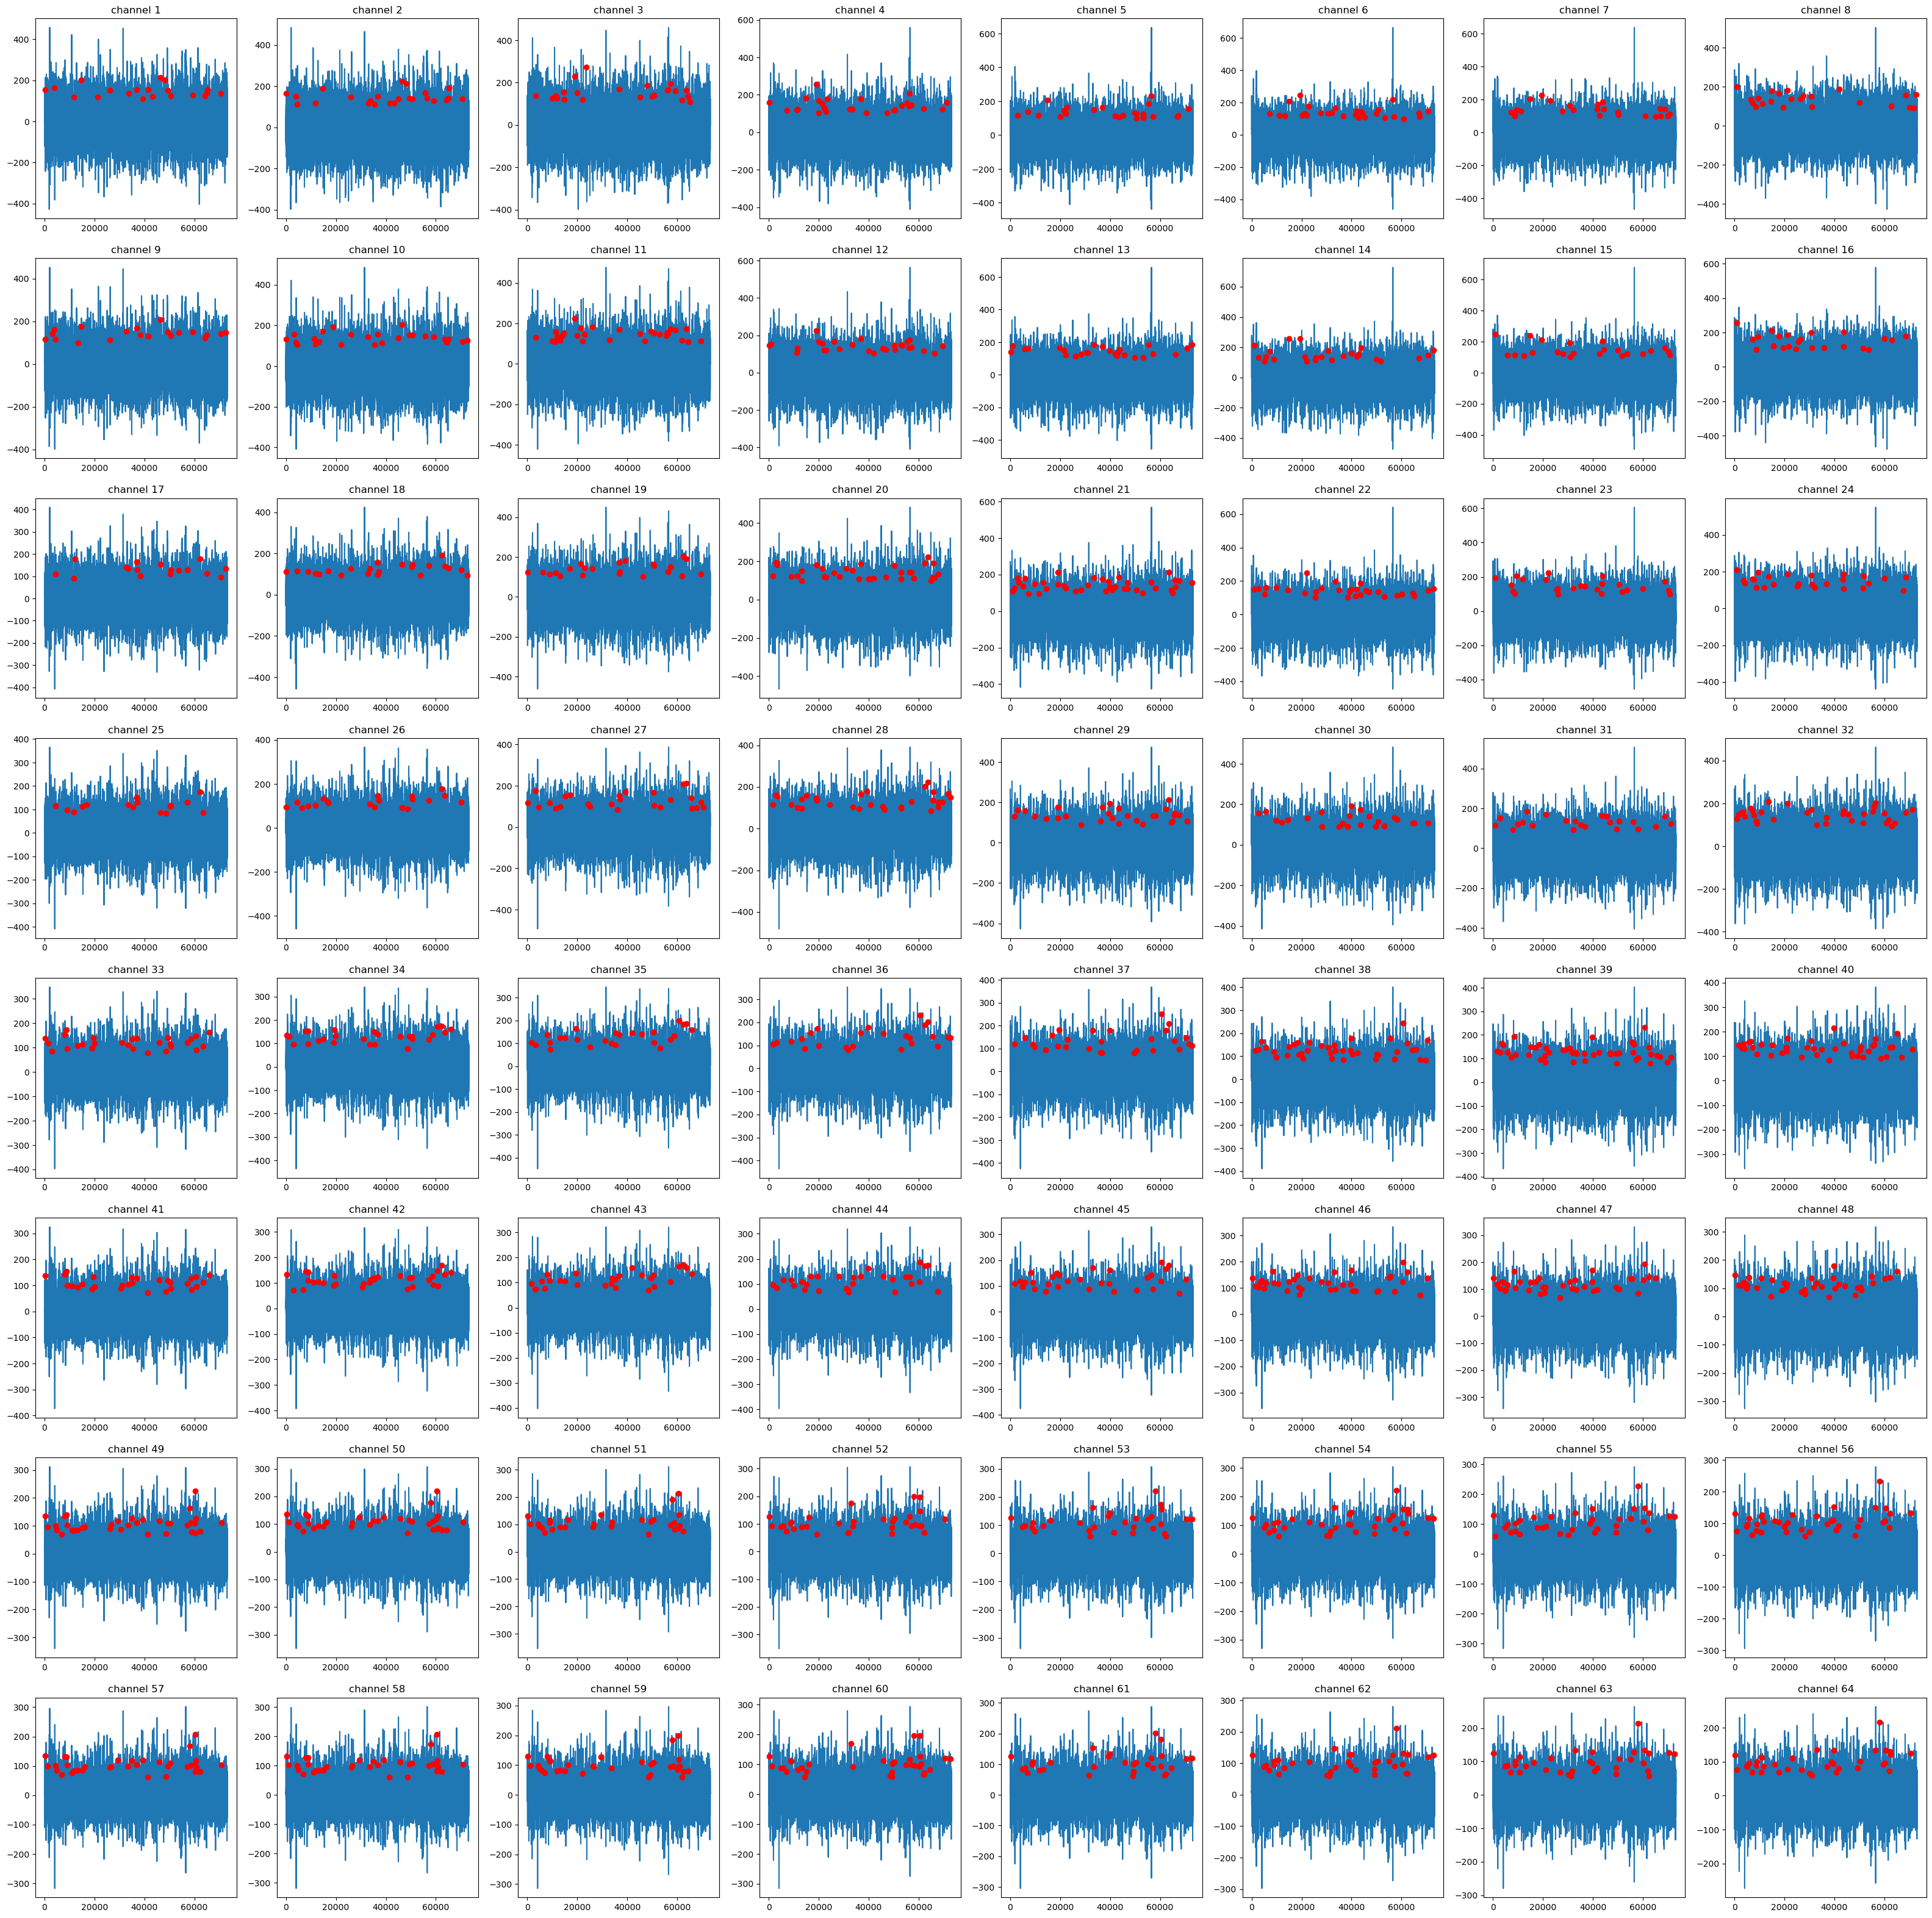

In [38]:
firings = viz_peaks(final_grid3,filtered_data3,2)

In [39]:
import pandas as pd

df = pd.DataFrame(firings,columns=['channel','position','unit'])
df.to_csv('increasing_force_3.csv')